# 제주 버스 승차인원 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import packages

In [ ]:
# 설치해야 할 것들
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install xgboost
!pip install catboost
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
import jinja2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pycaret.utils import enable_colab

from collections import Counter
from pycaret.regression import *

%matplotlib inline
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Travel/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Travel/data/test.csv")
bts = pd.read_csv("/content/drive/MyDrive/Travel/data/bus_bts.csv")

# 1. EDA

##### 구조확인 

In [ ]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
train.shape # 415423행 21열
test.shape # 228170행 20열

(228170, 20)

In [ ]:
# train / test 날짜 범위 비교
print('train_data_min',train.date.min())
print('train_data_max',train.date.max())
print('test_data_min',test.date.min())
print('test_data_max',test.date.max())

train_data_min 2019-09-01
train_data_max 2019-09-30
test_data_min 2019-10-01
test_data_max 2019-10-16


##### Station_name과 code가 1:1 매칭 안됨

* 정류장 이름은 여러 정류장 코드를 가짐
* 정류장 이름은 여러 정류장 좌표를 가짐

* 결론 : 정류장 이름은 대표성을 갖지 않음.

In [ ]:
#하나의 station name에 다수의 station_code 발견.
multi_station = train.groupby('station_name')['station_code'].nunique().sort_values()
multi_station

station_name
히귀반석        1
제주자동차검사소    1
제주은행        1
보목신협        1
보목신협앞       1
           ..
조수1리        5
비석거리        6
성읍1리        6
금악리         7
신안동         8
Name: station_code, Length: 1961, dtype: int64

In [ ]:
len(train['station_code'].unique()), len(train['station_name'].unique())
# station_code가 고유값임

(3563, 1961)

##### 요일별로 영향 확인


In [ ]:
ride_col_list = ['%d~%d_ride'%(i, i+1) for i in range(6, 12)] + ['18~20_ride']
takeoff_col_list = ['%d~%d_takeoff'%(i, i+1) for i in range(6, 12)] + ['18~20_ride']

In [ ]:
df_date_ride = train.groupby(['date']).sum()[ride_col_list].stack().reset_index()
df_date_ride.columns = ['date', 'ride_time', 'count']

df_date_takeoff = train.groupby(['date']).sum()[takeoff_col_list].stack().reset_index()
df_date_takeoff.columns = ['date', 'takeoff_time', 'count']
df_date_takeoff.head(5)

,date,takeoff_time,count
0,2019-09-01,6~7_takeoff,1343.0
1,2019-09-01,7~8_takeoff,2713.0
2,2019-09-01,8~9_takeoff,3671.0
3,2019-09-01,9~10_takeoff,4077.0
4,2019-09-01,10~11_takeoff,4510.0


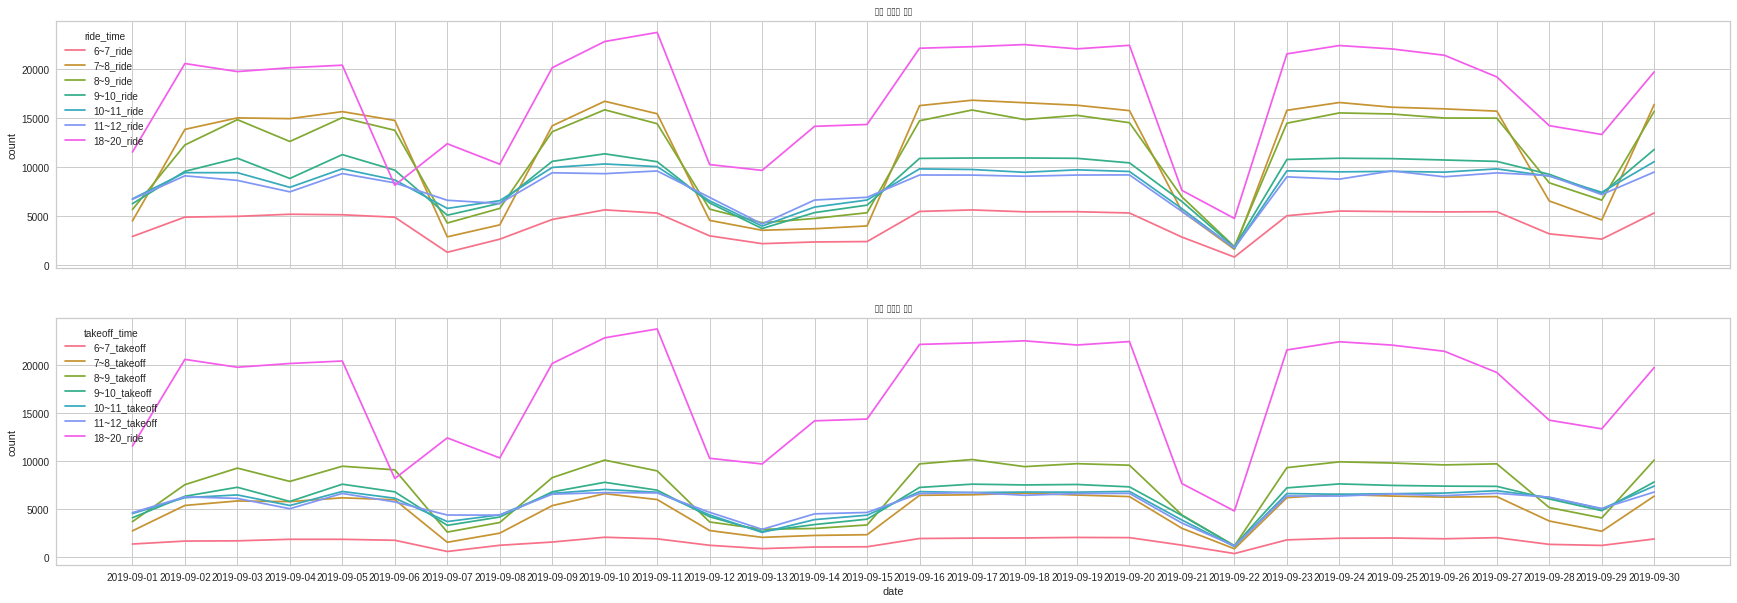

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

axes[0].set(title='일별 승차량 증감')
sns.lineplot(x='date', y='count', hue='ride_time', data=df_date_ride, ax=axes[0])

axes[1].set(title='일별 하차량 증감')
sns.lineplot(x='date', y='count', hue='takeoff_time', data=df_date_takeoff, ax=axes[1])

In [ ]:
# 공휴일 확인
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]

train['holiday'] = train.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
test['holiday'] = test.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
train.shape, test.shape

((415423, 22), (228170, 21))

In [ ]:
# 날씨 정보 비가오면 1, 그렇지 않으면 0
IsRainy = ['09-04', '09-05', '09-06', '09-07', '09-10', '09-11', '09-12', '09-13', '09-14', '09-22', 
            '10-02', '10-03', '10-05', '10-07']
IsRainy = ['2019-'+ day for day in IsRainy]

train['IsRainy'] = train.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)
test['IsRainy'] = test.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)

train.shape, test.shape

((415423, 23), (228170, 22))

In [ ]:
# 요일 구분
train['date'] = pd.to_datetime(train['date'])
train['week'] = train['date'].dt.weekday

test['date'] = pd.to_datetime(test['date'])
test['week'] = test['date'].dt.weekday

train.shape, test.shape

((415423, 24), (228170, 23))

In [ ]:
# 시내 시외 버스 1과 0으로 각각 변환
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

##### 주요 측정소

In [ ]:
# 지도 관련 시각화 
import folium 
from folium.plugins import MarkerCluster 
import geopy.distance 

In [ ]:
# 해당 주요 장소의 임의 지역 위도, 경도 (baseline 참조)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [ ]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

# 2. Data Cleansing / Feature Engineering

#### 2-1. 평일, 주말, 공휴일 별로 컬럼 생성.

In [ ]:
#date 변수 변환
train['date2'] = pd.to_datetime(train['date'])
test['date2']=pd.to_datetime(test['date'])
train['week'] = train['date2'].dt.weekday #요일별로 변수 변경(train)

test['date2'] = pd.to_datetime(test['date'])
test['week'] = test['date2'].dt.weekday #요일별로 변수 변경(test)

del train['date2'] #임의 컬럼 삭제
del test['date2']

In [ ]:
# week(평일), weekend(주말), holiday(공휴일)
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]

train['holiday'] = train.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
train['weekend'] = train.apply(lambda row: 1 if row.week in [5,6] else 0, axis=1)
train['Mon'] = train.apply(lambda row: 1 if row.week == 0 else 0, axis=1)
train['Tue'] = train.apply(lambda row: 1 if row.week == 1 else 0, axis=1)
train['Wed'] = train.apply(lambda row: 1 if row.week == 2 else 0, axis=1)
train['Thu'] = train.apply(lambda row: 1 if row.week == 3 else 0, axis=1)
train['Fri'] = train.apply(lambda row: 1 if row.week == 4 else 0, axis=1)

test['holiday'] = test.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
test['weekend'] = test.apply(lambda row: 1 if row.week in [5,6] else 0, axis=1)
test['Mon'] = test.apply(lambda row: 1 if row.week == 0 else 0, axis=1)
test['Tue'] = test.apply(lambda row: 1 if row.week == 1 else 0, axis=1)
test['Wed'] = test.apply(lambda row: 1 if row.week == 2 else 0, axis=1)
test['Thu'] = test.apply(lambda row: 1 if row.week == 3 else 0, axis=1)
test['Fri'] = test.apply(lambda row: 1 if row.week == 4 else 0, axis=1)

#### 2-2. 관측소와의 거리 컬럼 추가

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({0: 1479, 1: 659, 2: 597, 3: 828})

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

#### 2-3. 날씨 컬럼 추가
- 비가 오면 영향을 받을 것이라 추정 IsRainy 컬럼 추가

In [ ]:
# 날씨 정보 비가오면 1, 그렇지 않으면 0
IsRainy = ['09-04', '09-05', '09-06', '09-07', '09-10', '09-11', '09-12', '09-13', '09-14', '09-22', 
            '10-02', '10-03', '10-05', '10-07']
IsRainy = ['2019-'+ day for day in IsRainy]

train['IsRainy'] = train.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)
test['IsRainy'] = test.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)


#### 2-4. 승하차 시간 통합

- 현재 train, test data는 오전 시간대의 경우, 1시간마다의 승차, 하차 인원수를 표시해주고 있지만, 
예측하려고 하는 퇴근시간대의 경우, 2시간에 해당되는 승차 인원을 예측하여야 한다.
그렇기 때문에, 오전 시간대에 승차, 하차 인원수들도 2시간 간격으로 통합해주었다.

In [ ]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원 (2시간단위로 묶어줌)
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

In [ ]:
#test도 같이 묶어줌.
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

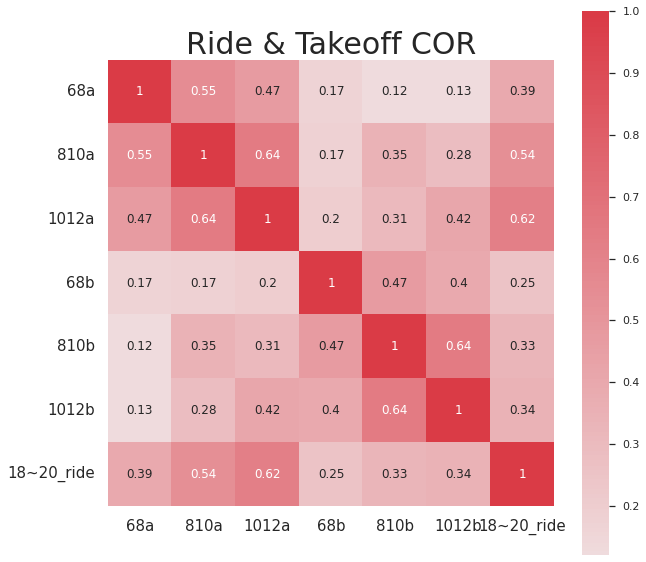

In [ ]:
train2=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train2.corr()

sns.set(style="white")
f,ax=plt.subplots(figsize=(10,10))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor, cmap=cmap,center=0,square=True,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=15)
plt.yticks(size=15,rotation=0)
plt.title("Ride & Takeoff COR",size=30);

In [ ]:
# 탑승

train['avg_68a'] = train.groupby(['date','bus_route_id'])['68a'].transform('mean')
train['avg_810a'] = train.groupby(['date','bus_route_id'])['810a'].transform('mean')
train['avg_1012a'] = train.groupby(['date','bus_route_id'])['1012a'].transform('mean')

test['avg_68a'] = test.groupby(['date','bus_route_id'])['68a'].transform('mean') 
test['avg_810a'] = test.groupby(['date','bus_route_id'])['810a'].transform('mean') 
test['avg_1012a'] = test.groupby(['date','bus_route_id'])['1012a'].transform('mean')  

In [ ]:
# 하차

train['avg_68b'] = train.groupby(['date','bus_route_id'])['68b'].transform('mean')
train['avg_810b'] = train.groupby(['date','bus_route_id'])['810b'].transform('mean')
train['avg_1012b'] = train.groupby(['date','bus_route_id'])['1012b'].transform('mean')

test['avg_68b'] = test.groupby(['date','bus_route_id'])['68b'].transform('mean') 
test['avg_810b'] = test.groupby(['date','bus_route_id'])['810b'].transform('mean') 
test['avg_1012b'] = test.groupby(['date','bus_route_id'])['1012b'].transform('mean')  

In [ ]:
# # 노선과 정류소 id를 합쳐보기
# train['bus_route_id'] = train['bus_route_id'].astype(str)
# train['station_code'] = train['station_code'].astype(str)
# train['route_station'] = train['bus_route_id'] + ',' + train['station_code']

# test['bus_route_id'] = test['bus_route_id'].astype(str)
# test['station_code'] = test['station_code'].astype(str)
# test['route_station'] = test['bus_route_id'] + ',' + test['station_code']

In [ ]:
# # 버스 노선과 요일
# train['bus_route_id_weekday'] = train['bus_route_id'].astype(str) + ',' + train['week'].astype(str) 
# test['bus_route_id_weekday'] = test['bus_route_id'].astype(str) + ',' + test['week'].astype(str) 

In [ ]:
# # 버스 정류소와 요일
# train['station_code_weekday'] = train['station_code'].astype(str) + ',' + train['week'].astype(str)
# test['station_code_weekday'] = test['station_code'].astype(str) + ',' + test['week'].astype(str)

In [ ]:
# # 노선과 정류소와 요일
# train['route_station_weekday'] = train['route_station'].astype(str) + ',' + train['week'].astype(str) 
# test['route_station_weekday'] = test['route_station'].astype(str) + ',' + test['week'].astype(str)

In [ ]:
# # 라벨 인코딩 해주기
# labelencoder = LabelEncoder()
# df_encode = train[['bus_route_id','station_code', 'route_station_weekday', 'route_station']]
# df_encoded = df_encode.apply(labelencoder.fit_transform)

# train['bus_route_id2']=df_encoded['bus_route_id']
# train['station_code2']=df_encoded['station_code']
# train['route_station_weekday2']=df_encoded['route_station_weekday']
# train['route_station2']=df_encoded['route_station']


# 3. Modeling

In [ ]:
# reproducibility 씨드의 배열은 랜덤하지 않게 유지하기 위한 장치
def seed_all(seed_num):
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)
    np.random.seed(seed_num)

seed_all(42)

In [ ]:
# 테이블에서 필요없는 컬럼들 제거하기(본 자료는 다 예시입니다.)
train_x = train.drop(['id', 'date', 'station_name', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff','7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff'], axis = 1)
test_x = test.drop(['id', 'date', 'station_name', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff','7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff'], axis = 1)
train_x.head()

,bus_route_id,in_out,station_code,18~20_ride,holiday,IsRainy,week,weekend,Mon,Tue,Wed,Thu,Fri,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,68a,810a,1012a,68b,810b,1012b,avg_68a,avg_810a,avg_1012a,avg_68b,avg_810b,avg_1012b
0,4270000,1,344,0.0,0,0,6,1,0,0,0,0,0,4.286659,37.692766,37.713630,27.841879,0,1.0,7.0,8.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
1,4270000,1,357,5.0,0,0,6,1,0,0,0,0,0,4.966848,37.008492,38.465822,27.996179,0,5.0,6.0,11.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
2,4270000,1,432,2.0,0,0,6,1,0,0,0,0,0,6.330746,35.642126,39.259820,27.496551,0,2.0,2.0,0.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
3,4270000,0,1579,53.0,0,0,6,1,0,0,0,0,0,3.575272,38.643401,38.386802,29.579404,0,17.0,32.0,30.0,0.0,0.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88
4,4270000,0,1646,0.0,0,0,6,1,0,0,0,0,0,30.652098,23.648361,45.899140,14.269792,3,0.0,0.0,0.0,0.0,1.0,0.0,1.28,2.24,2.72,0.16,0.32,1.88


In [ ]:
seed_num = 42
py_reg = setup(train_x, target = '18~20_ride', fold_shuffle = True, session_id = seed_num, use_gpu = True, normalize = True, silent = True, remove_outliers = True)
# 괄호 설명 : (사용할 데이터, 예측하고자 하는 컬럼, 샘플데이터를 섞음, 아까 정한 랜덤값을 설정으로 둠,
#              정규화, 나중에 밑에 많이 뜨는거 조용히ㅎ, 이상치 제거)

,Description,Value
0,session_id,42
1,Target,18~20_ride
2,Original Data,"(415423, 30)"
3,Missing Values,False
4,Numeric Features,18
5,Categorical Features,11
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(276256, 32)"


In [ ]:
best_models = compare_models(n_select=5, sort='RMSE')
# n_select는 사용할 파라미터의 갯수

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.8397,4.0683,2.0155,0.4994,0.4934,0.6647,146.457
lightgbm,Light Gradient Boosting Machine,0.8725,4.1276,2.0300,0.4923,0.4993,0.6491,1.778
catboost,CatBoost Regressor,0.8911,4.3732,2.0896,0.4622,0.5062,0.6593,14.190
et,Extra Trees Regressor,0.8865,4.4488,2.1077,0.4526,0.5169,0.6986,73.629
gbr,Gradient Boosting Regressor,0.9451,5.1297,2.2630,0.3694,0.5313,0.6766,72.176
knn,K Neighbors Regressor,0.9088,5.7656,2.3995,0.2908,0.5396,0.7687,140.666
lr,Linear Regression,1.0365,6.0654,2.4607,0.2545,0.5735,0.7205,0.194
lar,Least Angle Regression,1.0368,6.0655,2.4608,0.2545,0.5736,0.7206,0.126
ridge,Ridge Regression,1.0351,6.0669,2.4610,0.2543,0.5728,0.7203,0.141
br,Bayesian Ridge,1.0351,6.0701,2.4617,0.2539,0.5728,0.7204,0.491


In [ ]:
# 상위 3개 모델 생성
catboost = create_model('catboost', verbose = False)
rf = create_model('rf', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)
# verbose information grid 를 표시할지 말지? verbose False로 하면 표시 안함. 확인을 위해 해봐도 좋음

In [ ]:
# 세개의 모델을 블랜딩 해볼 수 있음(이 모델은 어디까지나 예시임)
blend_models = blend_models(estimator_list = [catboost, rf, lightgbm])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8468,3.8978,1.9743,0.5119,0.4828,0.6311
1,0.8424,3.4790,1.8652,0.5177,0.4867,0.6428
2,0.8557,4.2002,2.0494,0.5027,0.4859,0.6275
3,0.8615,4.1877,2.0464,0.5117,0.4882,0.6305
4,0.8462,3.5812,1.8924,0.5205,0.4898,0.6298
5,0.8690,4.7047,2.1690,0.4923,0.4881,0.6360
6,0.8613,4.0289,2.0072,0.5042,0.4878,0.6383
7,0.8397,3.9667,1.9917,0.5280,0.4828,0.6299
8,0.8417,3.9101,1.9774,0.5187,0.4810,0.6291


In [ ]:
# 마지막 학습, test 예측
final_model = finalize_model(blend_models)
prediction = predict_model(final_model, data = test_x)